In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import pandas as pd
import pickle
import glob
from PIL import Image
import math
from skimage.transform import resize

In [ ]:
# extract head image
def extract_head(img, xi,yi,xg,yg):
    x,y= np.shape(img)[0:2] # height and width of image
    
    # point entre les yeux
    xg=int(xg*y)
    yg=int(yg*x)
    
    #point sommet gauche
    xi=int(y*xi)
    yi=int(x*yi)
    
    head=img[yi:yi+(yg-yi)*2,xi:xi+(xg-xi)*2]
    return head

def extract_target(img,xtr,ytr):
    x,y = np.shape(img)[0:2] 
    target=[int(ytr*x),int(xtr*y)]  # correspondent aux coordonnées x, sur l'image python
    return target

In [3]:
num=['3','1','2','4']
def load_images_from_folder(folder,i):
    images = []
    img_path = []
    img_name = []
    
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv.resize(img, dsize=(224, 224), interpolation=cv.INTER_CUBIC))  # resize image
            #img_path.append(folder +"/" +filename)
            img_path.append('train/0000000'+ num[i]+"/" +filename) 
            img_name.append(filename)            
            
    return images, img_path, img_name

In [4]:
path_base_data="/content/gdrive/MyDrive/part_data" # database path
path_annotation="/content/gdrive/MyDrive/part_data/train_annotations.txt" #annotation path
directories=[x[0] for x in os.walk(path_base_data)] # list of different directories in database

In [ ]:
print(directories)

['/content/gdrive/MyDrive/part_data', '/content/gdrive/MyDrive/part_data/00000003', '/content/gdrive/MyDrive/part_data/00000001', '/content/gdrive/MyDrive/part_data/00000002', '/content/gdrive/MyDrive/part_data/00000004']


In [5]:
# base de donnée de test pour gaze estimation --> determiner alors gx,gy,gz, 
imgs=[]
imgs_heads=[] 
imgs_target=[]
imgs_name=[]
imgs_path=[]


In [6]:
# for all images
def get_images(directories):
    imgs = []
    imgs_path = []
    imgs_name = []
    for i in range (len(directories)-1):         
        img, img_path, img_name = load_images_from_folder(directories[i+1],i)
       
        imgs.append(img)  
        imgs_path.append(img_path)
        imgs_name.append(img_name)
                        
    return imgs, imgs_path, imgs_name

imgs, imgs_path, imgs_name = get_images(directories) 
# it takes 1.35 min to execute

(1, 4000, 224, 224, 3)


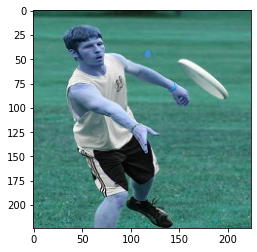

In [7]:
imgs = np.reshape(imgs,(1,4000,224,224,3))
print(np.shape(imgs))
imgs_path = np.reshape(imgs_path,(1,4000))
plt.imshow(imgs[0][0])

In [8]:
imgs_name = np.reshape(imgs_name,(1,4000))

In [9]:
with open('imgs_name_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [10]:
print(imgs_name[0][3999])

00004452.jpg


In [ ]:
# get information from the txt file
def get_annotation(path_annotation):
    with open(path_annotation, 'r') as f:
        annotations = [[num for num in line.split(',')] for line in f]
    f.close()
    annotations = np.array(annotations)
    return annotations

annotations = get_annotation(path_annotation)

In [ ]:
print(annotations[100][0], imgs_path[0][0])

train/00000072/00072708.jpg train/00000003/00003843.jpg


In [ ]:
def part_annotation(imgs, imgs_path, annotations):
  part_annot=[]
  for i in range (4000):
    l = 0  
    count=0  
    for k in annotations[:,0]:                       
      if k==imgs_path[0][i] and count==0:               
        part_annot.append(annotations[l])
        count=count+1
          
      l=l+1
  return part_annot

In [ ]:
part_annot= part_annotation(imgs, imgs_path, annotations)
# it takes  11 min to execute

In [ ]:
print(np.shape(part_annot))

(4000, 12)


In [ ]:
# build the head data, get target position 
def create_data(imgs, imgs_path, part_annot):
    imgs_heads=[]
    imgs_target=[]
   
    for i in range (4000):  
        
        target=np.zeros((np.shape(imgs)[0],2))
       
        img= extract_head(imgs[0][i],float(part_annot[i][2]),float(part_annot[i][3]),float(part_annot[i][6]),float(part_annot[i][7]))           
        target=extract_target(imgs[0][i],float(part_annot[i][8]),float(part_annot[i][9]))   
       
        imgs_heads.append(img)
        imgs_target.append(target) #vecteur ligne   
        
    return imgs_heads, imgs_target
    

In [ ]:
# gaze follow data
imgs_heads, imgs_target = create_data(imgs, imgs_path, part_annot)
# it takes  15 min to execute

In [ ]:
print(np.shape(imgs_heads))
print(np.shape(imgs_target))
print(np.shape(imgs))
print(np.shape(imgs_name))

(4000,)
(4000, 2)
(1, 4000, 224, 224, 3)
(1, 4000)
(0,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


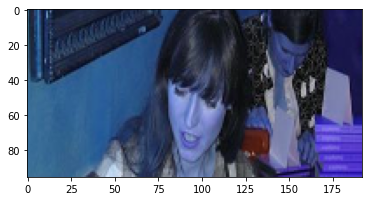

In [ ]:
plt.imshow(imgs[0][3191])
plt.imshow(imgs_heads[3191])
#plt.imshow(imgs_right_eye[2098])

In [ ]:
# create the pickle files
with open('imgs_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs, f)

with open('imgs_path_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_path, f)

with open('imgs_heads_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_heads, f)

with open('imgs_target_gaze_follow.pkl', 'wb') as f:
    pickle.dump(imgs_target, f)
